<a href="https://colab.research.google.com/github/maxlshk/python-big-data/blob/main/Project_Loshak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.1 MB/s eta 0:00:00


# Підготовка середовища та імпорт бібліотек

In [3]:
from google.colab import drive
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import itertools
import pandas as pd
import optuna

# Завантаження та розпакування датасету Intel Image Classification

Intel Image Classification - це набір даних, що містить зображення шести категорій: будівлі, ліси, льодовики, гори, море та вулиці.

Ми підключаємо Google Drive для доступу до архіву з датасетом та розпаковуємо його в робочу директорію. Датасет розділений на три частини:
- seg_train: зображення для навчання моделі
- seg_test: зображення для тестування моделі після навчання
- seg_pred: зображення для прогнозування без міток

Загалом датасет містить близько 25000 зображень розміром 150x150 пікселів.

In [4]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Intel_Image_Classification.zip'
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test'

!unzip -q {zip_path} -d /content/

Mounted at /content/drive


# Перетворення та аугментація даних
застосовуємо різні перетворення до зображень:

1. **Для навчального набору даних:**
   - Зміна розміру до 150x150 пікселів
   - Випадкове горизонтальне відображення для збільшення різноманітності даних
   - Випадкове обертання на 10 градусів для збільшення різноманітності даних
   - Перетворення в тензор
   - Нормалізація з використанням середніх значень та стандартних відхилень ImageNet

2. **Для тестового набору даних:**
   - Лише зміна розміру, перетворення в тензор та нормалізація

Аугментація даних допомагає моделі краще узагальнювати та запобігає перенавчанню.

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Завантаження та розділення датасету

У цьому розділі ми завантажуємо повний набір даних для навчання, а потім розділяємо його на тренувальну та валідаційну частини (80% та 20% відповідно). Тестовий набір даних завантажується окремо.

Для завантаження зображень використовуємо torchvision.datasets.ImageFolder, який автоматично призначає класи зображенням на основі структури директорій. Для розділення даних використовуємо random_split з PyTorch, який випадковим чином розділяє дані на підмножини заданого розміру.

In [6]:
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Створення DataLoader для ефективного завантаження даних

DataLoader - це клас у PyTorch, який допомагає нам ефективно завантажувати дані під час навчання моделі

Ми створюємо три DataLoader:
1. **train_loader** - для тренувальних даних з перемішуванням
2. **val_loader** - для валідаційних даних без перемішування
3. **test_loader** - для тестових даних без перемішування

Розмір пакету (batch_size) встановлено на 32, що є компромісом між швидкістю навчання та використанням пам'яті.

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Функція для візуалізації зображень


In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

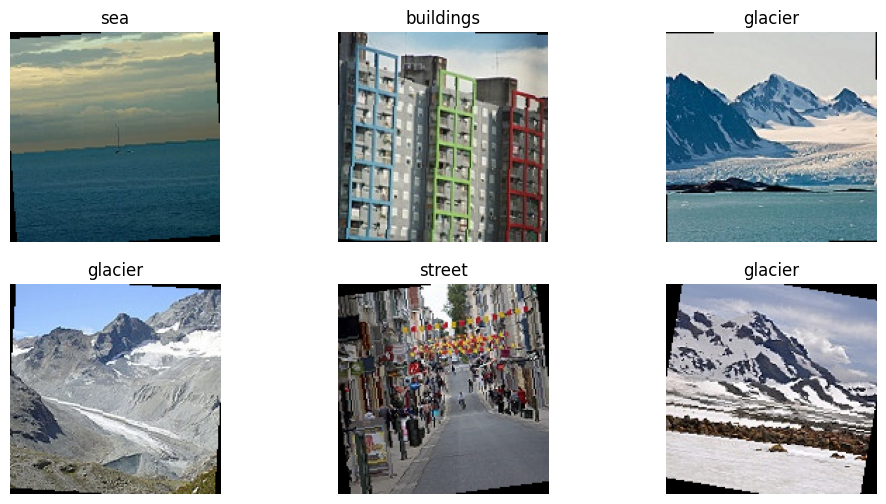

In [9]:
inputs, classes = next(iter(train_loader))
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    imshow(inputs[i], title=full_train_dataset.classes[classes[i]])
plt.show()

# Розподіл класів у тренувальному наборі даних

Цей графік показує кількість зображень для кожного класу в тренувальному наборі даних.

In [10]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

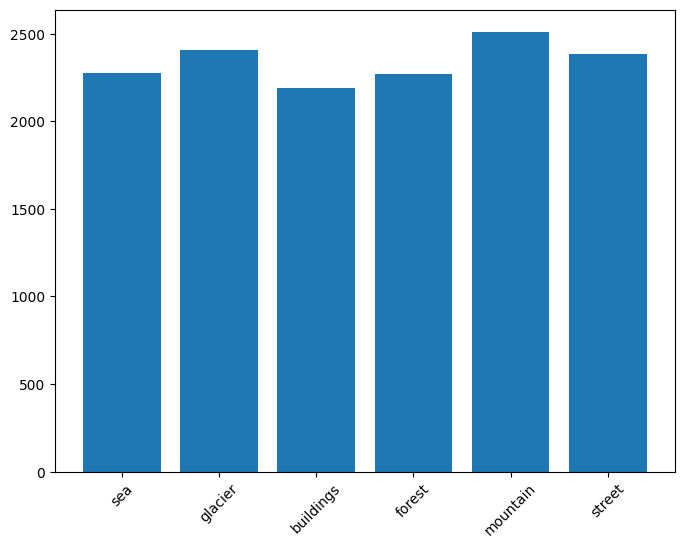

In [11]:
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.show()


# Архітектура простої згорткової нейронної мережі (CNN)

визначаємо архітектуру простої згорткової нейронної мережі (CNN) для класифікації зображень.

1. **Згорткові шари:**
   - Перший шар: 3 -> 32 канали (для обробки RGB зображень)
   - Другий шар: 32 -> 64 канали
   - Третій шар: 64 -> 128 каналів
   
   Кожен згортковий шар включає:
   - Згортку з ядром 3x3 з відступом 1
   - Активацію ReLU для введення нелінійності
   - Макс-пулінг з розміром 2x2 для зменшення просторових розмірів

2. **Адаптивний пулінг** для отримання фіксованого розміру виходу незалежно від розміру вхідного зображення

3. **Повнозв'язні шари:**
   - Перший FC шар: 128 -> 128 нейронів
   - Dropout з ймовірністю 0.5 для запобігання перенавчанню
   - Другий FC шар: 128 -> 6 нейронів (по одному для кожного класу)


In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss/val_total:.4f} Acc: {val_correct/val_total:.4f}")


Epoch 1/20 - Train Loss: 1.2758 Acc: 0.4601 | Val Loss: 1.0274 Acc: 0.5932
Epoch 2/20 - Train Loss: 1.0152 Acc: 0.5864 | Val Loss: 0.9652 Acc: 0.5700
Epoch 3/20 - Train Loss: 0.9030 Acc: 0.6352 | Val Loss: 0.8606 Acc: 0.6441
Epoch 4/20 - Train Loss: 0.8234 Acc: 0.6802 | Val Loss: 0.7364 Acc: 0.7186
Epoch 5/20 - Train Loss: 0.7695 Acc: 0.7079 | Val Loss: 0.6942 Acc: 0.7321
Epoch 6/20 - Train Loss: 0.7230 Acc: 0.7278 | Val Loss: 0.6385 Acc: 0.7620
Epoch 7/20 - Train Loss: 0.6806 Acc: 0.7445 | Val Loss: 0.5971 Acc: 0.7870
Epoch 8/20 - Train Loss: 0.6320 Acc: 0.7608 | Val Loss: 0.5657 Acc: 0.8087
Epoch 9/20 - Train Loss: 0.6085 Acc: 0.7802 | Val Loss: 0.5494 Acc: 0.8041
Epoch 10/20 - Train Loss: 0.5683 Acc: 0.7948 | Val Loss: 0.5096 Acc: 0.8240
Epoch 11/20 - Train Loss: 0.5613 Acc: 0.7964 | Val Loss: 0.5010 Acc: 0.8269
Epoch 12/20 - Train Loss: 0.5316 Acc: 0.8084 | Val Loss: 0.5536 Acc: 0.7944
Epoch 13/20 - Train Loss: 0.5267 Acc: 0.8125 | Val Loss: 0.4729 Acc: 0.8343
Epoch 14/20 - Train L

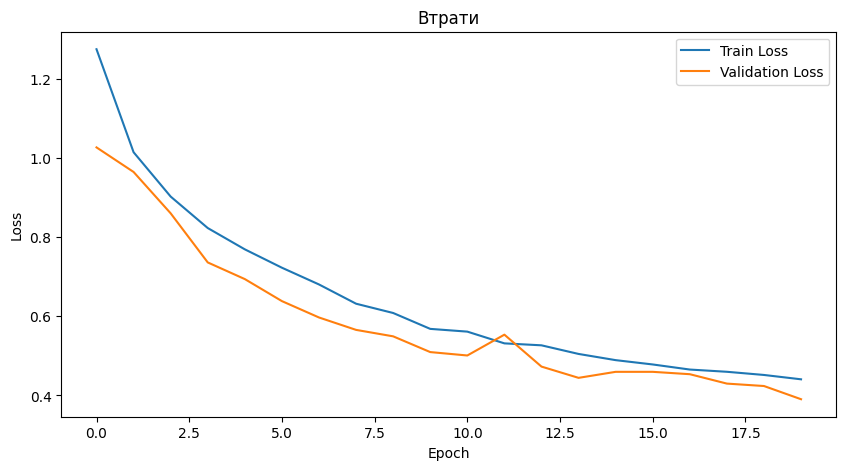

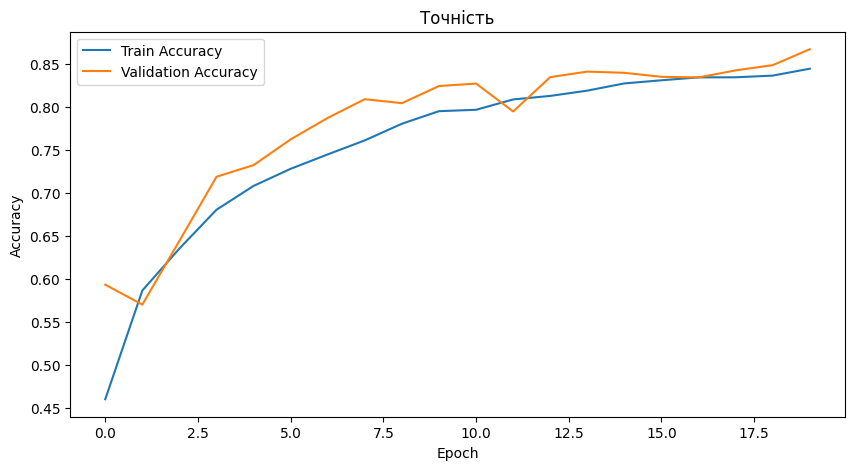

In [39]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Втрати")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Точність")
plt.legend()
plt.show()

# Оптимізована архітектура CNN з гнучкими гіперпараметрами

це удосконалена версія нашої попередньої CNN моделі, яка дозволяє гнучко налаштовувати основні гіперпараметри архітектури:

1. **num_conv_layers** - кількість згорткових шарів (від 2 до 4)
2. **dense_units** - кількість нейронів у повнозв'язному шарі (128, 256 або 512)

Ця модель динамічно створює згорткові шари на основі заданої кількості. Для перших трьох шарів використовуються фіксовані кількості фільтрів (32, 64, 128), а для додаткових шарів (якщо num_conv_layers > 3) кількість фільтрів збільшується вдвічі відносно попереднього шару.


In [16]:
class SimpleCNNOpt(nn.Module):
    def __init__(self, num_conv_layers=3, dense_units=128, num_classes=6):
        super().__init__()
        layers = []
        in_channels = 3
        filters = [32, 64, 128]

        for i in range(num_conv_layers):
            out_channels = filters[i] if i < 3 else filters[-1] * (2 ** (i - 2))
            layers += [
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            ]
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_channels, dense_units)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(dense_units, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [17]:
def run_experiment(lr, conv_layers, dense_units, num_epochs=5):
    model = SimpleCNNOpt(conv_layers, dense_units).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = correct / total
        if acc > best_acc:
            best_acc = acc

    return best_acc, model


In [18]:
learning_rates = [0.001, 0.0001, 0.01]
conv_layers_options = [2, 3, 4]
dense_units_options = [128, 256, 512]

results = []
for lr, layers, units in itertools.product(learning_rates, conv_layers_options, dense_units_options):
    acc, _ = run_experiment(lr, layers, units)
    results.append((lr, layers, units, acc))

# Оптимізація гіперпараметрів за допомогою Optuna


In [19]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    layers = trial.suggest_int("layers", 2, 4)
    units = trial.suggest_categorical("units", [128, 256, 512])

    acc, _ = run_experiment(lr, layers, units)
    return acc

In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_params = study.best_trial.params
final_model = SimpleCNNOpt(best_params['layers'], best_params['units']).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])

for epoch in range(20):
    final_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

[I 2025-04-24 16:40:33,507] A new study created in memory with name: no-name-222470d7-782e-473b-a399-62af365d0455
[I 2025-04-24 16:42:11,867] Trial 0 finished with value: 0.18061987887424297 and parameters: {'lr': 0.007573354035475459, 'layers': 4, 'units': 256}. Best is trial 0 with value: 0.18061987887424297.
[I 2025-04-24 16:43:49,010] Trial 1 finished with value: 0.8012112575703598 and parameters: {'lr': 0.0013457498339701085, 'layers': 3, 'units': 512}. Best is trial 1 with value: 0.8012112575703598.
[I 2025-04-24 16:45:28,381] Trial 2 finished with value: 0.7189169932312077 and parameters: {'lr': 0.00011486991807768435, 'layers': 4, 'units': 512}. Best is trial 1 with value: 0.8012112575703598.
[I 2025-04-24 16:47:04,847] Trial 3 finished with value: 0.73459209120057 and parameters: {'lr': 0.003443425566933285, 'layers': 2, 'units': 256}. Best is trial 1 with value: 0.8012112575703598.
[I 2025-04-24 16:48:43,388] Trial 4 finished with value: 0.6775917349483435 and parameters: {'l

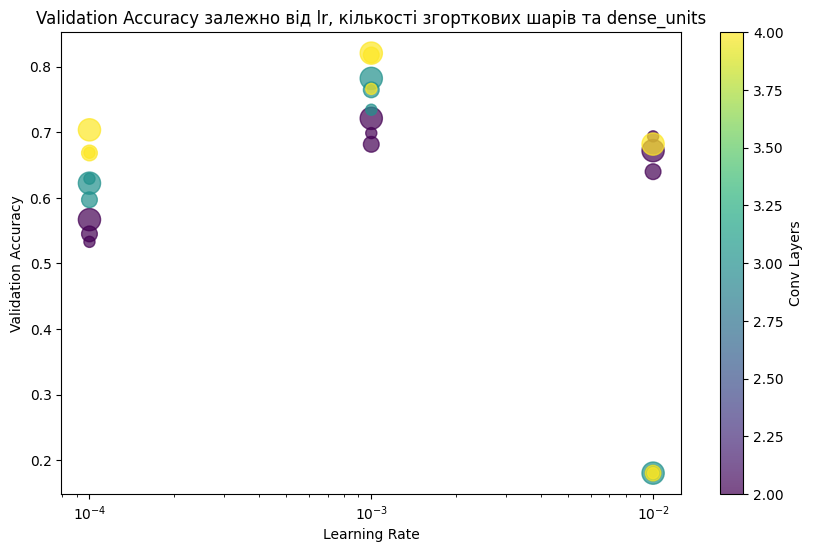

In [41]:
plt.figure(figsize=(10,6))
results_df = pd.DataFrame(results, columns=["learning_rate", "conv_layers", "dense_units", "accuracy"])
plt.scatter(results_df["learning_rate"], results_df["accuracy"],
           c=results_df["conv_layers"], s=results_df["dense_units"]/2, alpha=0.7)
plt.colorbar(label="Conv Layers")
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy залежно від lr, кількості згорткових шарів та dense_units")
plt.show()

**Завантаження попередньо навченої моделі**:
   - Використовуємо ResNet50 з ваговими коефіцієнтами ImageNet

**Модифікація моделі для нашого завдання**:
   - Заморожуємо перші 6 шарів моделі (вони містять низькорівневі фільтри, які корисні для будь-якого завдання комп'ютерного зору)
   - Замінюємо останній повнозв'язний шар на новий з 6 виходами (відповідно до кількості наших класів)



In [30]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 6:
        for param in child.parameters():
            param.requires_grad = False

model_ft.fc = nn.Linear(model_ft.fc.in_features, 6)
model_ft = model_ft.to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20
best_acc = 0.0

for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model_ft.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item() * inputs.size(0)

    val_acc = val_correct / val_total
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss/val_total:.4f} Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model_ft.state_dict()

model_ft.load_state_dict(best_model_wts)

Epoch 1/20 | Train Loss: 0.3325 Acc: 0.8872 | Val Loss: 0.2122 Acc: 0.9312
Epoch 2/20 | Train Loss: 0.2110 Acc: 0.9245 | Val Loss: 0.2011 Acc: 0.9334
Epoch 3/20 | Train Loss: 0.1747 Acc: 0.9365 | Val Loss: 0.2342 Acc: 0.9238
Epoch 4/20 | Train Loss: 0.1391 Acc: 0.9529 | Val Loss: 0.2494 Acc: 0.9202
Epoch 5/20 | Train Loss: 0.1145 Acc: 0.9602 | Val Loss: 0.2315 Acc: 0.9213
Epoch 6/20 | Train Loss: 0.0677 Acc: 0.9774 | Val Loss: 0.2036 Acc: 0.9387
Epoch 7/20 | Train Loss: 0.0455 Acc: 0.9857 | Val Loss: 0.2083 Acc: 0.9352
Epoch 8/20 | Train Loss: 0.0377 Acc: 0.9874 | Val Loss: 0.2192 Acc: 0.9366
Epoch 9/20 | Train Loss: 0.0270 Acc: 0.9927 | Val Loss: 0.2274 Acc: 0.9394
Epoch 10/20 | Train Loss: 0.0226 Acc: 0.9935 | Val Loss: 0.2496 Acc: 0.9309
Epoch 11/20 | Train Loss: 0.0212 Acc: 0.9941 | Val Loss: 0.2442 Acc: 0.9348
Epoch 12/20 | Train Loss: 0.0201 Acc: 0.9941 | Val Loss: 0.2358 Acc: 0.9359
Epoch 13/20 | Train Loss: 0.0190 Acc: 0.9947 | Val Loss: 0.2243 Acc: 0.9412
Epoch 14/20 | Train L

<All keys matched successfully>

In [31]:
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print(f"Transfer Learning Test Acc: {accuracy_score(test_labels, test_preds):.4f}")

Transfer Learning Test Acc: 0.9380


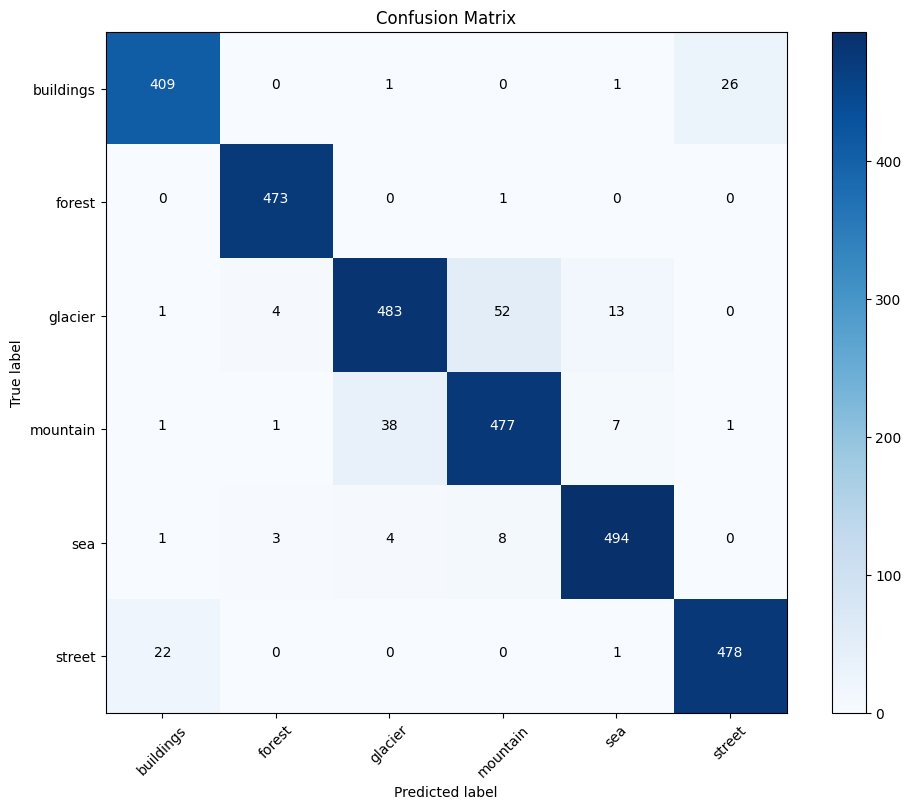

In [33]:
class_names = full_train_dataset.classes
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Як можна помітити по гарній синій діагоналі на матриці, модель гарно справляється з розпізнаванням усіх об'єктів, найбільше труднощів виникає з горами та льодовиками, що й логічно, бо льодовик це по суті гора льоду) Щоб перевірити наскільки правдива ця теза давайте виведемо всі унікальні класи зображень, де модель зробила помилку.

Found 19 unique misclassification patterns


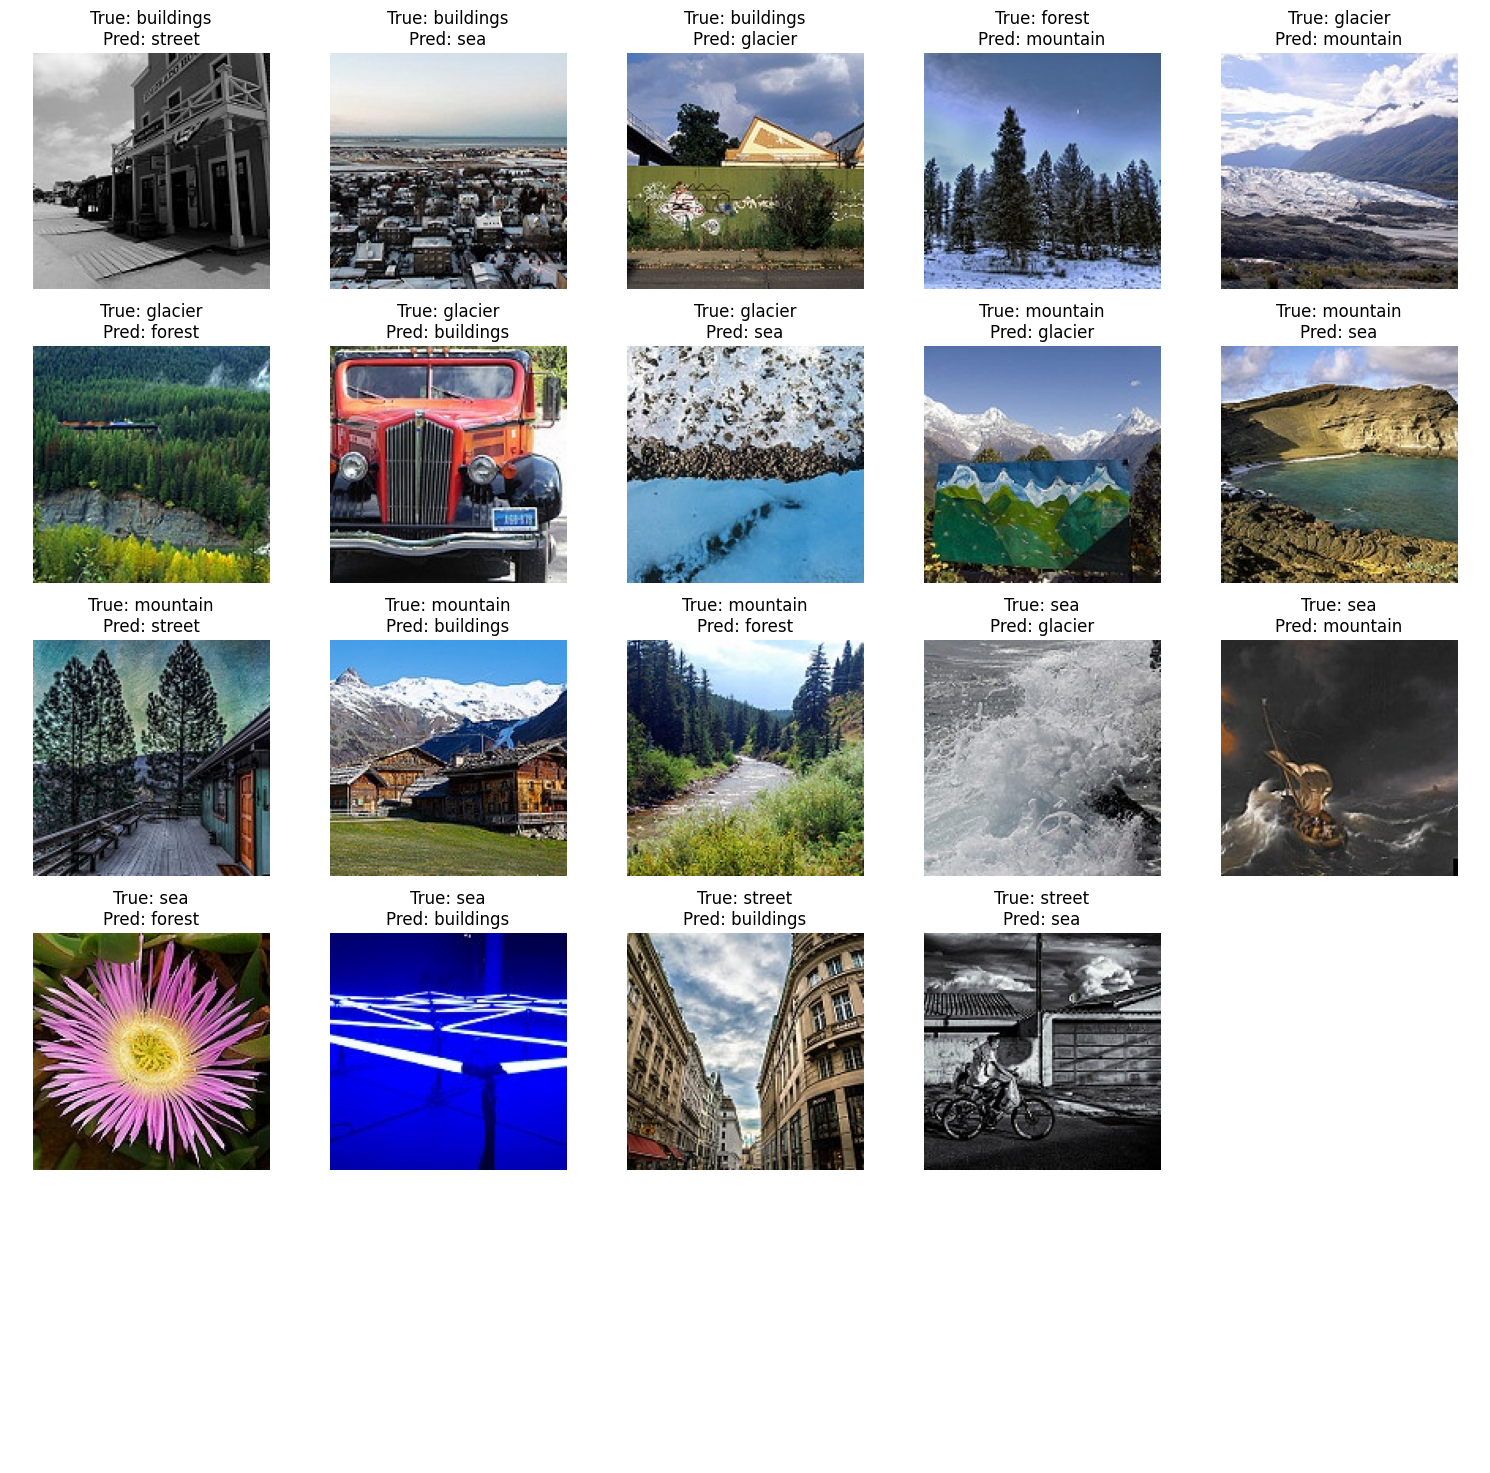

In [43]:
unique_misclassifications = {}
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(inputs.size(0)):
            if preds[i] != labels[i]:
                true_class = labels[i].item()
                pred_class = preds[i].item()
                key = (true_class, pred_class)
                if key not in unique_misclassifications:
                    unique_misclassifications[key] = inputs[i].cpu()

print(f"Found {len(unique_misclassifications)} unique misclassification patterns")

grid_size = int(np.ceil(np.sqrt(len(unique_misclassifications))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, ((true, pred), img) in enumerate(unique_misclassifications.items()):
    if i < len(axes):
        ax = axes[i]
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'True: {class_names[true]}\nPred: {class_names[pred]}')
        ax.axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

Дякую за цей чудовий курс! 🙂